<a href="https://colab.research.google.com/github/marlonrcfranco/soyforecast/blob/master/soyforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soyforecast
By [Marlon Franco]()
/ [GitHub](https://github.com/marlonrcfranco/soyforecast.git)

####Prediction of future soybeans stock prices on the Chicago Stock Exchange (CBOT) using a LSTM model and relating climatic data from the most productive regions of the USA.

![alt text](https://github.com/marlonrcfranco/soyforecast/blob/master/Selection_244.png?raw=true)

#### Soybean, CBOT Soybean Futures
- https://blog.quandl.com/api-for-commodity-data
- http://www.quandl.com/api/v3/datasets/CHRIS/CME_S1/

#### 2015 USA Weather Avg, Max, Min
- https://data.world/mattwinter225/2015-usa-weather-avg-max-min

#### USDA-NASS-soybeans-production_bushels-2015
- https://usda-reports.nautilytics.com/?crop=soybeans&statistic=production_dollars&year=2007
- https://www.nass.usda.gov/Data_Visualization/index.php


## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import os
from six.moves import urllib

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


In [2]:
tf.__version__

'1.13.1'

In [3]:
tf.keras.__version__

'2.2.4-tf'

In [4]:
pd.__version__

'0.22.0'

## Defines

In [0]:
DATASETMARLON_URL = "https://raw.githubusercontent.com/marlonrcfranco/soyforecast/master/datasets/DatasetMarlon/datasetmarlon.csv"
DATASETMARLON_PATH = "datasets/DatasetMarlon/"

START_IDX=0 #Start-index for the time-series.
LENGHT=100000 #Sequence-length to process and plot.

#plt.rcParams["figure.figsize"] = [19,15]
#plt.rcParams.update({'font.size': 27})

## Fetch Data



In [0]:
def fetch_datasetmarlon_data(datasetmarlon_url=DATASETMARLON_URL, datasetmarlon_path=DATASETMARLON_PATH):
    if not os.path.isdir(datasetmarlon_path):
        os.makedirs(datasetmarlon_path)
    csv_path = os.path.join(datasetmarlon_path, "datasetmarlon.csv")
    urllib.request.urlretrieve(datasetmarlon_url, csv_path)

    

In [0]:
fetch_datasetmarlon_data()

## Load Data


In [0]:
def load_datasetmarlon_data(datasetmarlon_path=DATASETMARLON_PATH):
    csv_path = os.path.join(datasetmarlon_path, "datasetmarlon.csv")
    print(csv_path)
    return pd.read_csv(csv_path)
 

In [9]:
datasetmarlon = load_datasetmarlon_data()
datasetmarlon['Date'] = pd.to_numeric(pd.to_datetime(datasetmarlon['Date']).dt.strftime("%Y%m%d"))
datasetmarlon.head()

datasets/DatasetMarlon/datasetmarlon.csv


,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,mintemp,maxtemp,avgtemp
0,20151231,875.00,879.25,870.0,871.00,4.25,871.25,12579.0,18252.0,34.460251,46.761506,40.964435
1,20151230,870.00,878.25,869.0,874.25,5.50,875.50,26033.0,27996.0,37.656904,48.531381,42.717573
2,20151229,866.50,876.25,865.0,869.75,5.00,870.00,45812.0,41805.0,36.161426,49.008386,42.352201
3,20151228,873.00,874.50,864.0,867.00,10.25,865.00,41472.0,58158.0,36.243697,50.836134,43.277311
4,20151224,882.75,885.00,875.0,877.00,6.50,875.25,31325.0,71137.0,45.413866,61.670168,53.792017


### Target Data for Prediction

We will try and predict these signals.

In [0]:
target_names = ['Settle','avgtemp']

The following is the number of time-steps that we will shift the target-data. Our data-set is resampled to have an observation for each hour, so there are 24 observations for 24 hours.

If we want to predict the weather 24 hours into the future, we shift the data 24 time-steps. If we want to predict the weather 7 days into the future, we shift the data 7 * 24 time-steps.

In [0]:
shift_days = 1
shift_steps = shift_days
#shift_steps = shift_days * 24  # Number of hours.

Create a new data-frame with the time-shifted data.

**Note the negative time-shift!**

In [0]:
df_targets = datasetmarlon[target_names].shift(-shift_steps)

**WARNING!** You should double-check that you have shifted the data in the right direction! We want to predict the future, not the past!

The shifted data-frame is confusing because Pandas keeps the original time-stamps even though we have shifted the data. You can check the time-shift is correct by comparing the original and time-shifted data-frames.

This is the first `shift_steps + 5` rows of the original data-frame:

In [13]:
datasetmarlon[target_names].head(shift_steps + 5)

,Settle,avgtemp
0,871.25,40.964435
1,875.50,42.717573
2,870.00,42.352201
3,865.00,43.277311
4,875.25,53.792017
5,881.75,55.421053


The following is the first 5 rows of the time-shifted data-frame. This should be identical to the last 5 rows shown above from the original data, except for the time-stamp.

In [14]:
df_targets.head(5)

,Settle,avgtemp
0,875.50,42.717573
1,870.00,42.352201
2,865.00,43.277311
3,875.25,53.792017
4,881.75,55.421053


The time-shifted data-frame has the same length as the original data-frame, but the last observations are `NaN` (not a number) because the data has been shifted backwards so we are trying to shift data that does not exist in the original data-frame.

In [15]:
df_targets.tail()

,Settle,avgtemp
247,1052.5,23.234177
248,1051.0,29.141649
249,1039.5,27.235169
250,1002.0,37.373134
251,NaN,NaN


### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

In [0]:
x_data = datasetmarlon.values[0:-shift_steps]

In [17]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (251, 12)


These are the output-signals (or target-signals):

In [0]:
y_data = df_targets.values[:-shift_steps]

In [19]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (251, 2)


This is the number of observations (aka. data-points or samples) in the data-set:

In [20]:
num_data = len(x_data)
num_data

251

This is the fraction of the data-set that will be used for the training-set:

In [0]:
train_split = 0.9

This is the number of observations in the training-set:

In [22]:
num_train = int(train_split * num_data)
num_train

225

This is the number of observations in the test-set:

In [23]:
num_test = num_data - num_train
num_test

26

These are the input-signals for the training- and test-sets:

In [24]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

251

These are the output-signals for the training- and test-sets:

In [25]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

251

This is the number of input-signals:

In [26]:
num_x_signals = x_data.shape[1]
num_x_signals

12

This is the number of output-signals:

In [27]:
num_y_signals = y_data.shape[1]
num_y_signals

2

### Scaled Data

The data-set contains a wide range of values:

In [28]:
print (x_train)

[[2.01512310e+07 8.75000000e+02 8.79250000e+02 ... 3.44602510e+01
  4.67615063e+01 4.09644351e+01]
 [2.01512300e+07 8.70000000e+02 8.78250000e+02 ... 3.76569038e+01
  4.85313808e+01 4.27175732e+01]
 [2.01512290e+07 8.66500000e+02 8.76250000e+02 ... 3.61614256e+01
  4.90083857e+01 4.23522013e+01]
 ...
 [2.01502130e+07 9.82500000e+02 9.97500000e+02 ... 2.00318471e+01
  4.34267516e+01 3.06942675e+01]
 [2.01502120e+07 9.77500000e+02 9.85000000e+02 ... 2.04216102e+01
  4.29470339e+01 3.22245763e+01]
 [2.01502110e+07 9.70500000e+02 9.81000000e+02 ... 2.51340426e+01
  5.03574468e+01 3.73744681e+01]]


In [29]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.25
Max: 20151231.0


The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use `scikit-learn` for this.

We first create a scaler-object for the input-signals.

In [0]:
x_scaler = MinMaxScaler()

We then detect the range of values from the training-data and scale the training-data.

In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)

Apart from a small rounding-error, the data has been scaled to be between 0 and 1.

In [32]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


We use the same scaler-object for the input-signals in the test-set.

In [0]:
x_test_scaled = x_scaler.transform(x_test)

The target-data comes from the same data-set as the input-signals, because it is merely time-shifted. But the target-data could be from a different source with different value-ranges, so we create a separate scaler-object for the target-data.


In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Data Generator

The data-set has now been prepared as 2-dimensional numpy arrays. The training-data has 225 observations, consisting of 12 input-signals and 1 output-signals.

These are the array-shapes of the input and output data:

In [35]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(225, 12)
(225, 2)


Instead of training the Recurrent Neural Network on the complete sequences of 225 observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

We will use a large batch-size so as to keep the GPU near 100% work-load. You may have to adjust this number depending on your GPU, its RAM and your choice of `sequence_length` below.

In [0]:
batch_size = 115

We will use a sequence-length of 1, which means that each random sequence contains observations for 1 day. One time-step corresponds to one day.

In [38]:
sequence_length = 1
#sequence_length = 24 * 7 * 8
sequence_length

1

We then create the batch-generator.

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

We can then test the batch-generator to see if it works.

In [0]:
x_batch, y_batch = next(generator)

This gives us a random batch of 115 sequences, each sequence having 1 observation, and each observation having 12 input-signals and 1 output-signal.

In [41]:
print(x_batch.shape)
print(y_batch.shape)

(115, 1, 12)
(115, 1, 2)


We can plot one of the 12 input-signals as an example.

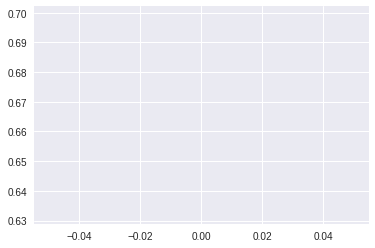

In [42]:
batch = 0   # First sequence in the batch.
signal = 6  # 'Settle' signal from the 12 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

We can also plot one of the output-signals that we want the model to learn how to predict given all those 12 input signals.

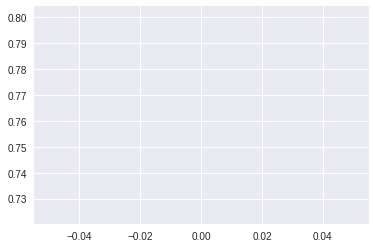

In [43]:
signal = 0 
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity.

In [0]:
model = Sequential()

We can now add a Gated Recurrent Unit (GRU) to the network. This will have 512 outputs for each time-step in the sequence.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by `None`), where each observation has a number of input-signals (`num_x_signals`).

In [46]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

Instructions for updating:
Colocations handled automatically by placer.


The GRU outputs a batch of sequences of 512 values. We want to predict 3 output-signals, so we add a fully-connected (or dense) layer which maps 512 values down to only 3 values.

The output-signals in the data-set have been limited to be between 0 and 1 using a scaler-object. So we also limit the output of the neural network using the Sigmoid activation function, which squashes the output to be between 0 and 1.

In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))

A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has temperatures between -20 and +30 degrees, then the scaler-object will map -20 to 0 and +30 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to temperature values between -20 and +30.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid `NaN` values during training. You may need to experiment with this to get it working.

In [0]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Loss Function

We will use Root Mean Squared Error (RMSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.


In [0]:
warmup_steps = 100

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """
    
    #return loss_mean
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred))))

### Compile Model

This is the optimizer and the beginning learning-rate that we will use.

In [0]:
optimizer = RMSprop(lr=1e-3)

We then compile the Keras model so it is ready for training.

In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

This is a very small model with only two layers. The output shape of `(None, None, 3)` means that the model will output a batch with an arbitrary number of sequences, each of which has an arbitrary number of observations, and each observation has 1 signal. This corresponds to the 1 target signal we want to predict.

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         806400    
_________________________________________________________________
dense (Dense)                (None, None, 2)           1026      
Total params: 807,426
Trainable params: 807,426
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [0]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=7, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [0]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=0`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a few minutes.

Also note that the loss sometimes becomes `NaN` (not-a-number). This is often resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.

In [59]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
1/1 [==============================] - 0s 104ms/sample - loss: 0.1318

Epoch 00001: val_loss improved from inf to 0.13177, saving model to 23_checkpoint.keras
100/100 [==============================] - 5s 50ms/step - loss: 0.1120 - val_loss: 0.1318
Epoch 2/20
1/1 [==============================] - 0s 36ms/sample - loss: 0.1364

Epoch 00002: val_loss did not improve from 0.13177

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 4s 41ms/step - loss: 0.0605 - val_loss: 0.1364
Epoch 3/20
1/1 [==============================] - 0s 31ms/sample - loss: 0.1210

Epoch 00003: val_loss improved from 0.13177 to 0.12102, saving model to 23_checkpoint.keras
100/100 [==============================] - 4s 41ms/step - loss: 0.0540 - val_loss: 0.1210
Epoch 4/20
1/1 [==============================] - 0s 32ms/sample - loss: 0.1253

Epoch 00004: val_loss did not improve from 0.12102

Epoch 00004: ReduceLROnPlateau reducing 

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [61]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 52ms/sample - loss: 0.1178


In [62]:
print("loss (test-set):", result)

loss (test-set): 0.11784499138593674


In [0]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## Generate Predictions

This helper-function plots the predicted and true output-signals.

In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

We can now plot an example of predicted output-signals. It is important to understand what these plots show, as they are actually a bit more complicated than you might think.

These plots only show the output-signals and not the 12 input-signals used to predict the output-signals. The time-shift between the input-signals and the output-signals is held fixed in these plots. The model **always** predicts the output-signals e.g. 1 day into the future (as defined in the `shift_steps` variable above). So the plot's x-axis merely shows how many time-steps of the input-signals have been seen by the predictive model so far.

Let us start with an example from the training-data. This is data that the model has seen during training so it should perform reasonably well on this data.

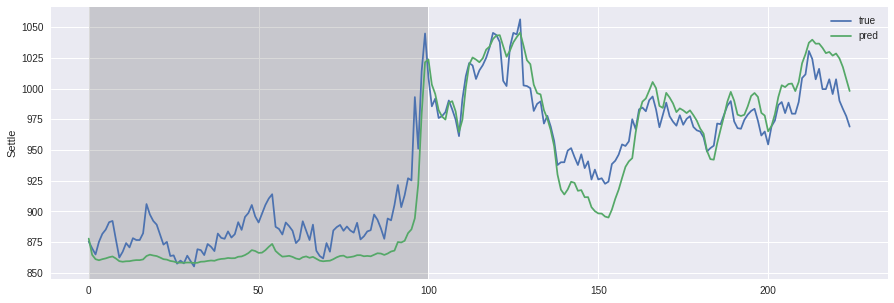

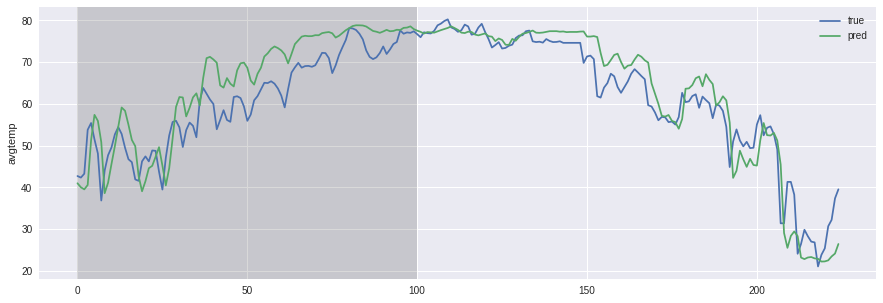

In [65]:
plot_comparison(start_idx=START_IDX, length=LENGHT, train=True)

The model was able to predict the overall oscillations quite well but the peaks were sometimes inaccurate.

### Example from Test-Set

Now consider an example from the test-set. The model has not seen this data during training.

The 'Settle' is predicted reasonably well, although the peaks are sometimes inaccurate.

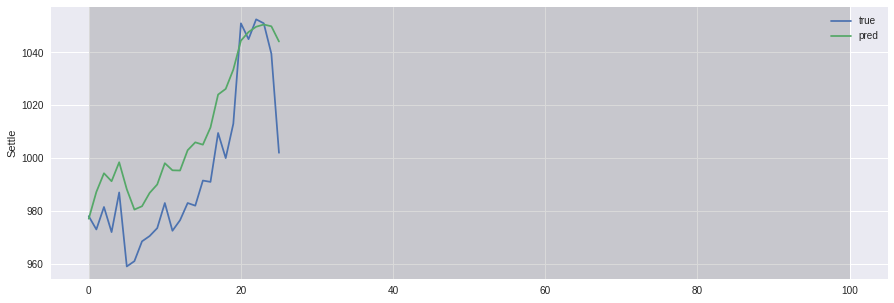

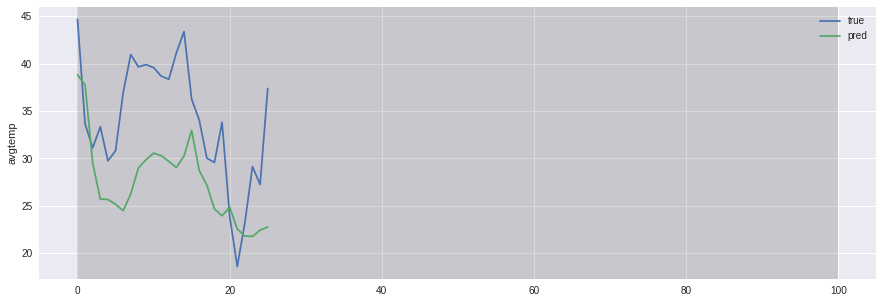

In [66]:
plot_comparison(start_idx=START_IDX, length=LENGHT, train=False)

## Conclusion

It worked reasonably well for predicting the 'Settle' where the daily oscillations were predicted well, but the peaks were sometimes not predicted so accurately..

## License (MIT)

Copyright (c) 2018 by [Marlon Franco]()

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.